### Predicting dog breeds using a CNN (Convolutional Neural Network) and transfer learning

This project aims to classify the breed of a dog from breeds given its image. This is done using CNNs and transfer learning.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))


# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    

'''
    Use pre-trained VGG-16 model to classify a given image as either contains a dog or doesn't contain a dog
    
    Args:
        img_path: path to an image
    
        
    Returns:
        Whether the image contains a dog or not
    '''
def dog_detector(img_path):
    

    train_transforms = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomRotation((90,90)),
                                transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    img = plt.imread(img_path)
    img_transformed = train_transforms(img)
    img_transformed = img_transformed.unsqueeze(0).cuda()
    prediction = VGG16(img_transformed).detach().cpu().numpy()
    topClass = np.argmax(prediction, axis=1)
    if topClass>=151 and topClass <= 268:
        return True
    return False

In [3]:
import os
from torchvision import datasets
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

img_size = 224 # Size all images are resized to (all images will be resized to img_sizeximg-size)
batch_size = 32 # Number of images per batch
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

# Function to apply transforms to the training data
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

# Function to apply transforms to the validtion/testing data
val_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

data_dir = './dogImages'
traindir = os.path.join(data_dir,'train')
validdir = os.path.join(data_dir,'valid')
testdir = os.path.join(data_dir,'test')

# Creating training, validation, and testing datasets
train_data = datasets.ImageFolder(traindir, transform=train_transforms)
valid_data = datasets.ImageFolder(validdir, transform=val_transforms)
test_data = datasets.ImageFolder(testdir, transform=val_transforms)

# Creating training, validation and testing dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,num_workers=8)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,num_workers=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=1)

# loaders object has all 3 dataloaders (training, validation, and testing)
loaders = {
    'train':trainloader,
    'valid':validloader,
    'test':testloader
}

In [1]:
from tqdm import tqdm

'''
Trains a model given the training hyperparameters

Args:
    n_epochs: number of epochs/iterations to run the training loop (going over all data each epoch)
    loaders: an object that has 'train', 'valid', and 'test' dataloaders
    model: the pytorch model to train
    optimizer: the pytorch optimizer used to train the model (Ex: Adam, SGD)
    scheduler: pytorch scheduler used to reduce the learning rate during training
    criterion: the criterion used to calculate the loss (Ex: CrossEntropy, NLLLoss)
    use_cuda: True if the training should run on the gpu. False if the training should run on the cpu
    save_path: the path to use to save the best model

Returns:
    The model after it has been trained and saved at 'save_path'
'''
def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path):
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_corrects = 0
        valid_corrects = 0
        
        scheduler.step()
        ###################
        # train the model #
        ###################
        model.train()
        for (data, target) in tqdm(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            # Find the model's prediction
            output = model(data)
            
            # Find the loss and update the model parameters accordingly
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
             # Update the average training loss
            train_loss += loss.item()
            
            # Update the average training accuracy
            pred = output.data.max(1, keepdim=True)[1]
            train_corrects += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            
           
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for (data, target) in tqdm(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # Find the model's prediction
            output = model(data)
            
            # Find the loss and update the average validation loss
            loss = criterion(output,target)
            valid_loss += loss.item()
            
            # Update the validation accuracy
            pred = output.data.max(1, keepdim=True)[1]
            valid_corrects += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

            
        train_loss = train_loss / len(loaders['train'])
        trainAcc = train_corrects/len(loaders['train'])
        valid_loss = valid_loss/(len(loaders['valid']))
        validAcc = valid_corrects/len(loaders['valid'])
        
        # Print training/validation statistics 
        print('Epoch: {} \nTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch, 
            train_loss,
            trainAcc,
            valid_loss,
            validAcc
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            
            # Save the model
            checkpoint = model.state_dict()
            torch.save(checkpoint, save_path)
            
    print("The best model had validation loss = "+str(valid_loss_min)) 
            
    # Return trained model
    return model

'''
Tests a model given testing data and prints the testing loss and accuracy

Args:
    loaders: an object that has 'train', 'valid', and 'test' dataloaders
    model: the pytorch model to train
    criterion: the criterion used to calculate the loss (Ex: CrossEntropy, NLLLoss)
    use_cuda: True if the training should run on the gpu. False if the training should run on the cpu


'''
def test(loaders, model, criterion, use_cuda):

    # Monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # Move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # Find the model's prediction
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        
        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # Update the test accuracy
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
     
    # Print test loss and accuracy
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

#### I will be using the resnet50 architecure and will use a model that is pretrained on ImageNet

In [5]:
import torch.nn as nn

# Specify model architecture
model_transfer = models.resnet50(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
num_features = model_transfer.fc.in_features

model_transfer.fc = nn.Linear(num_features,133)

print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [6]:
import torch.optim as optimizer

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optimizer.Adam(model_transfer.fc.parameters(),lr=0.001)
scheduler_transfer = optimizer.lr_scheduler.StepLR(optimizer_transfer,step_size=3,gamma=0.1)

In [7]:
# Train the model
model_transfer =  train(15, loaders, model_transfer, optimizer_transfer,scheduler_transfer, criterion_transfer, use_cuda, 'model_transfer_5.pt')

# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer_5.pt'))

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.86it/s]


Epoch: 1 
Training Loss: 2.853231 	Training Accuracy: 12.631579 	Validation Loss: 1.070740 	Validation Accuracy: 22.444444


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.82it/s]


Epoch: 2 
Training Loss: 1.533006 	Training Accuracy: 19.555024 	Validation Loss: 0.712686 	Validation Accuracy: 24.629630


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.90it/s]


Epoch: 3 
Training Loss: 1.289965 	Training Accuracy: 21.177033 	Validation Loss: 0.613274 	Validation Accuracy: 24.740741


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.86it/s]


Epoch: 4 
Training Loss: 1.020214 	Training Accuracy: 23.449761 	Validation Loss: 0.462405 	Validation Accuracy: 26.333333


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.90it/s]


Epoch: 5 
Training Loss: 0.952400 	Training Accuracy: 24.100478 	Validation Loss: 0.452894 	Validation Accuracy: 26.407407


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.91it/s]


Epoch: 6 
Training Loss: 0.997928 	Training Accuracy: 23.803828 	Validation Loss: 0.467362 	Validation Accuracy: 26.148148


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.88it/s]


Epoch: 7 
Training Loss: 0.959308 	Training Accuracy: 24.291866 	Validation Loss: 0.451636 	Validation Accuracy: 26.370370


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.91it/s]


Epoch: 8 
Training Loss: 0.976214 	Training Accuracy: 24.033493 	Validation Loss: 0.441004 	Validation Accuracy: 26.518519


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.92it/s]


Epoch: 9 
Training Loss: 0.958447 	Training Accuracy: 24.081340 	Validation Loss: 0.440553 	Validation Accuracy: 26.481481


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.91it/s]


Epoch: 10 
Training Loss: 0.951981 	Training Accuracy: 24.421053 	Validation Loss: 0.446505 	Validation Accuracy: 26.481481


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.88it/s]


Epoch: 11 
Training Loss: 0.963007 	Training Accuracy: 24.129187 	Validation Loss: 0.436511 	Validation Accuracy: 26.481481


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.94it/s]


Epoch: 12 
Training Loss: 0.947895 	Training Accuracy: 24.430622 	Validation Loss: 0.445489 	Validation Accuracy: 26.518519


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.93it/s]


Epoch: 13 
Training Loss: 0.945793 	Training Accuracy: 24.454545 	Validation Loss: 0.448221 	Validation Accuracy: 26.592593


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.93it/s]


Epoch: 14 
Training Loss: 0.954172 	Training Accuracy: 24.373206 	Validation Loss: 0.435059 	Validation Accuracy: 26.518519


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.92it/s]


Epoch: 15 
Training Loss: 0.960732 	Training Accuracy: 24.229665 	Validation Loss: 0.438782 	Validation Accuracy: 26.444444
The best model had validation loss = 0.43505859375


In [8]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.463371


Test Accuracy: 87% (730/836)


In [9]:
from torch.autograd import Variable

dog_classes = np.array(glob("dogImages/train/*")) # Will contain class names with the correct indices
for i in range(len(dog_classes)):
    fileName = dog_classes[i]
    startIndex = fileName.index(".")
    dog_classes[i] = fileName[startIndex+1:].replace("_"," ")


def predict_breed_transfer(img_path):
    
    # Load the image and return the predicted breed
    image = Image.open(img_path)
    image = val_transforms(image).float()
    image = Variable(image,requires_grad = False)
    npimg = np.transpose(image.numpy(),(2,1,0))
    plt.imshow(npimg, interpolation="none")
    plt.axis('off')
    image = image.unsqueeze(0).cuda()
    output = model_transfer(image)
    prediction = output.data.max(1, keepdim=True)[1]
    predictedClass = dog_classes[prediction[0][0]]
    return predictedClass

def run_app(img_path):
    dog_detected = dog_detector(img_path)
    if dog_detected:
        predictedBreed = predict_breed_transfer(img_path)
        print("Dog detected")
        print("Its breed is "+predictedBreed)
    else:
        print("No dog detected in the image. Please use another image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dog detected
Its breed is German shepherd dog


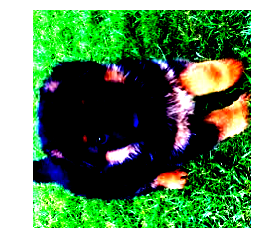

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

run_app('myTests/germanPuppy.jpg')